# Load csv

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('data/training_solutions_rev1/training_solutions_rev1.csv')

df_train, df_test = train_test_split(df, test_size=.2)
df_train.shape, df_test.shape

((49262, 38), (12316, 38))

# Create, Crop and resize XTrain 

In [8]:
from skimage.transform import resize
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
          

ORIG_SHAPE = (424,424)
CROP_SIZE = (256,256)
IMG_SHAPE = (64,64)

def get_image(path, x1,y1, shape, crop_size):
    x = plt.imread(path)
    x = x[x1:x1+crop_size[0], y1:y1+crop_size[1]]
    x = resize(x, shape)
    x = x/255.
    return x
    
def get_all_images(dataframe, shape=IMG_SHAPE, crop_size=CROP_SIZE):
    x1 = (ORIG_SHAPE[0]-CROP_SIZE[0])//2
    y1 = (ORIG_SHAPE[1]-CROP_SIZE[1])//2
   
    sel = dataframe.values
    ids = sel[:,0].astype(int).astype(str)
    y_batch = sel[:,1:]
    x_batch = []
    for i in tqdm(ids):
        x = get_image('data/images_training_rev1/'+i+'.jpg', x1,y1, shape=shape, crop_size=crop_size)
        x_batch.append(x)
    x_batch = np.array(x_batch)
    return x_batch, y_batch
        
X_train, y_train = get_all_images(df_train)
X_test, y_test = get_all_images(df_test)

100%|██████████| 12316/12316 [02:15<00:00, 90.80it/s] 


In [9]:
#Rename Test
X_val = X_test.copy()
y_val = y_test.copy()

In [10]:
print('X_train',X_train.shape)
print('y_train',y_train.shape)
print('X_val',X_val.shape)
print('y_val',y_val.shape)


X_train (49262, 64, 64, 3)
y_train (49262, 37)
X_val (12316, 64, 64, 3)
y_val (12316, 37)


In [11]:
np.save('X_train', X_train)
np.save('y_train', y_train)
np.save('X_val', X_val)
np.save('y_val', y_val)

# Load npy if already save

In [3]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

# Reduction of dimension by PCA

In [21]:
X_train[1].shape

(64, 64, 3)

In [12]:
X_train_r = X_train.reshape(49262,12288)

In [24]:
#Instantiate model
from sklearn.decomposition import PCA
pca_model = PCA()
inputs = [:1000]
pca_model.fit(inputs)
cumsum = np.cumsum(pca_model.explained_variance_ratio_)
nb_dim95 = np.argmax(cumsum >= 0.95) + 1

In [26]:
print("Dimension number", X_train_r.shape[1]-1)
print("Dimension number, explaining 95% of variance :", nb_dim95)

Dimension number 12287
Dimension number, explaining 95% of variance : 242


In [ ]:
pca_dims = PCA(n_components=nb_dim95)
X_pca_train = pca_dims.fit_transform(X_train)
X_pca_val = pca_dims.fit_transform(X_val)

# CNN model

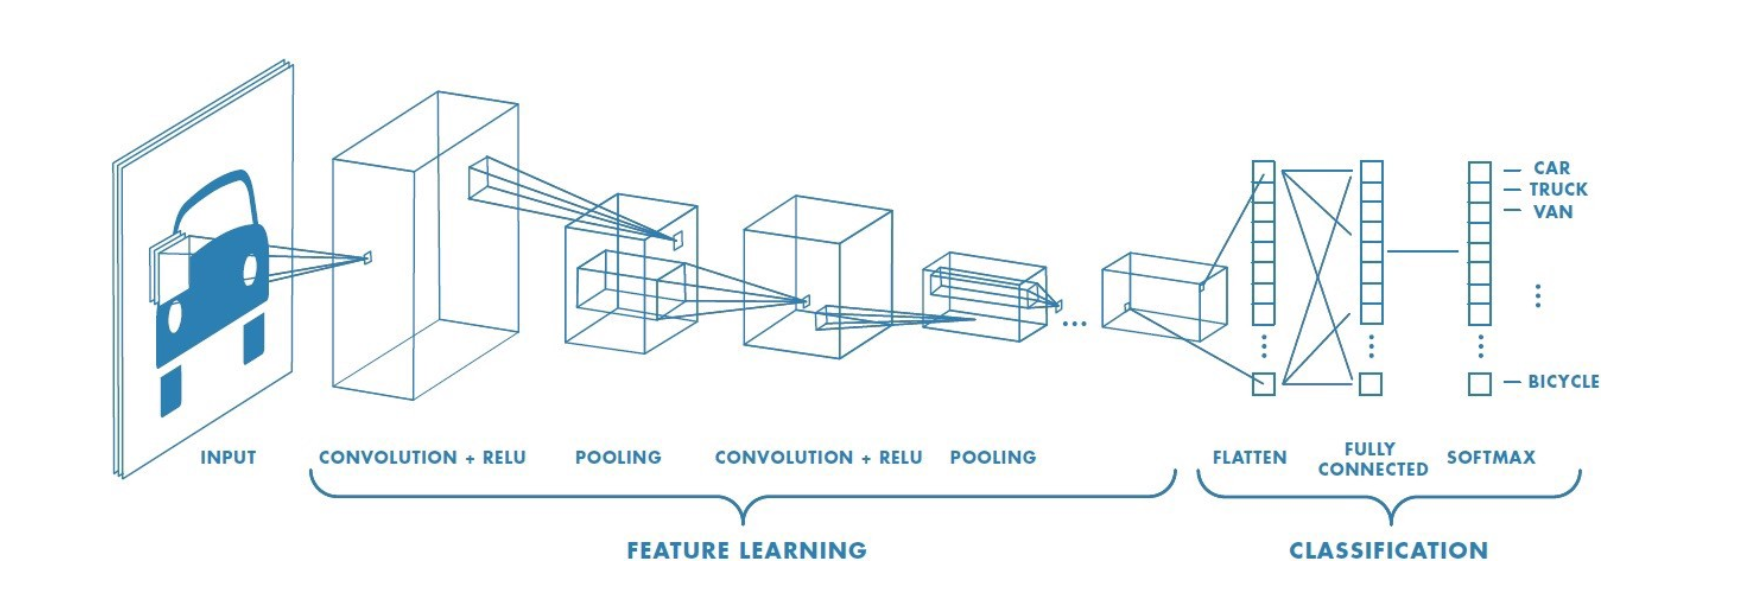

In [22]:
from IPython.display import Image
Image("cnn.png")

**Definition:**  
[keras doc](https://keras.io/layers/core/)  

* Conv2D : 
``` 
keras.backend.conv2d(x, kernel, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1))
```
  
* Dropout : Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.    
* Flatten : Flattens the input. Does not affect the batch size  


In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalMaxPooling2D
from keras import backend as K

#def root_mean_squared_error(y_true, y_pred):
#        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()

model.add(Conv2D(512, (3, 3), input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 3)))
model.add(Conv2D(256, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Conv2D(128, (3, 3)))
#model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(GlobalMaxPooling2D())


model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(37))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=[accuracy])
model.summary()

Using TensorFlow backend.





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 512)       14336     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 256)       1179904   
_________________________________________________________________
activation_1 (Activation)    (None, 60, 60, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 256)       590080    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 128)       295040    
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 128)       0         
__________

In [17]:
#batch_size = 128
#batch_size = 49262
epochs=10
history = model.fit(X_train[:20], y_train[:20], epochs=epochs, validation_data=(X_val[:20], y_val[:20]))

Train on 20 samples, validate on 20 samples
Epoch 1/10


20/20 [==============================] - 10s 477ms/step - loss: 0.6931 - root_mean_squared_error: 0.4274 - val_loss: 0.6886 - val_root_mean_squared_error: 0.4292
Epoch 2/10
20/20 [==============================] - 8s 381ms/step - loss: 0.6881 - root_mean_squared_error: 0.4244 - val_loss: 0.6136 - val_root_mean_squared_error: 0.3840
Epoch 3/10
20/20 [==============================] - 8s 381ms/step - loss: 0.6201 - root_mean_squared_error: 0.3841 - val_loss: 0.4790 - val_root_mean_squared_error: 0.3048
Epoch 4/10
20/20 [==============================] - 8s 381ms/step - loss: 0.6324 - root_mean_squared_error: 0.3652 - val_loss: 0.5023 - val_root_mean_squared_error: 0.3129
Epoch 5/10
20/20 [==============================] - 8s 382ms/step - loss: 0.5522 - root_mean_squared_error: 0.3439 - val_loss: 0.5478 - val_root_mean_squared_error: 0.3409
Epoch 6/10
20/20 [==============================] - 8s 378ms/step - loss: 0.5668 - root_mean_squared_error: 0.3509 - val_loss: 0.5376 - val_root_mean_

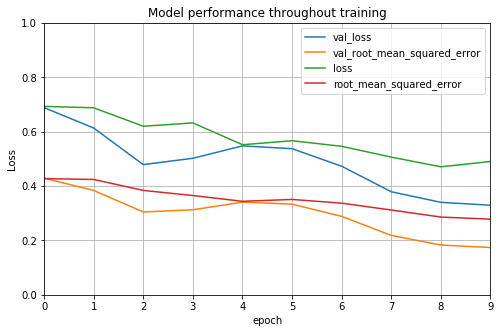

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.title('Model performance throughout training')
plt.ylim(0,1)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()
